**Автор**: Ермекова Асель

В этом домашнем задании вам предстоит реализовать VAE для датасета картинок MNIST.

Вы научитесь обучать вариационный автоэнкодер (VAE) генерировать новые изображения с нуля. А также сможете управлять генерацией, указывая желаемый класс объекта, и оценивать качество результата с помощью метрики FID.

Это домашнее задание состоит из двух частей:

* **I часть.** Реализовать безусловную генерацию картинок при помощи VAE тренированную на датасете MNIST и оценить качество по метрике FID.
* **II часть.** Реализовать условную генерацию по классу и оценить качество по метрике FID.





     

Установите библиотеку для подсчета FID:

In [ ]:
!pip install pytorch-fid

## **I часть. Unconditional VAE (6 баллов)**

### Библиотеки

In [ ]:
# TODO
# Импортните любые необходимые вам библиотеки
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch
import os
import random
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import copy

### Датасет.

**Задание**: Скачайте датасет MNIST и подготовьте train dataloader.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Подготовка данных ---
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Also define test_dataset here for later use (e.g., FID calculation)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.35MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.46MB/s]

Number of training samples: 60000
Number of test samples: 10000


**Задание**: Для FID сохраните 10k реальных изображений из MNIST test части в папку

In [ ]:
# TODO: Для FID сохраните 10k реальных изображений из MNIST test части в папку
os.makedirs('mnist_vae_real', exist_ok=True)

for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    save_image(img, f'mnist_vae_real/real_{i:05d}.png')

**Задание**: Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных

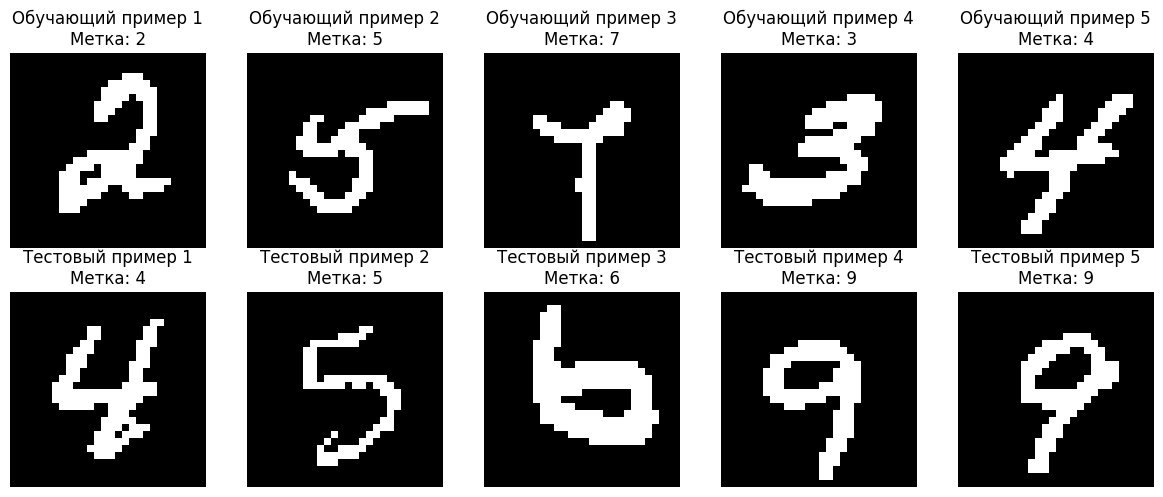

In [ ]:
# TODO
fig, axes = plt.subplots(2, 5, figsize = (12, 5))

# Отображение примеров из обучающей выборки
for idx in range(5):
    sample_idx = random.randint(0, len(train_dataset)-1)
    image, target = train_dataset[sample_idx]
    axes[0, idx].imshow(image[0], cmap = 'gray')
    axes[0, idx].set_title(f'Обучающий пример {idx+1}\nМетка: {target}')
    axes[0, idx].axis('off')

# Отображение примеров из тестовой выборки
for j in range(5):
    sample_idx = random.randint(0, len(test_dataset) - 1)
    image, target = test_dataset[sample_idx]
    axes[1, j].imshow(image[0], cmap='gray')
    axes[1, j].set_title(f'Тестовый пример {j+1}\nМетка: {target}')
    axes[1, j].axis('off')

plt.tight_layout()
plt.show()

### Модель

**Задание**: Реализуйте VAE архитектуру

In [ ]:
# ODO: РеализуTйте VAE (безусловный)
class VAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, hidden_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # Encoder: преобразует изображение в mu и logvar
        # Decoder: преобразует z обратно в изображение

        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 32, 4, 2, 1),  # уменьшаем размерность до 14x14
            nn.ReLU(),  # нелинейная активация
            nn.Conv2d(32, 64, 4, 2, 1),  # уменьшаем размерность до 7x7
            nn.ReLU(),  # нелинейная активация
            nn.Flatten(),  # преобразуем в одномерный вектор
            nn.Linear(3136, hidden_dim),  # переходим к вектору размерности hidden_dim
            nn.ReLU(),  # нелинейная активация
            nn.Linear(hidden_dim, 2 * latent_dim)  # получаем параметры распределения
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),  # расширяем latent вектор
            nn.ReLU(),  # нелинейная активация
            nn.Linear(hidden_dim, 3136),  # подготавливаем к преобразованию в изображение
            nn.ReLU(),  # нелинейная активация
            nn.Unflatten(1, (64, 7, 7)),  # восстанавливаем тензорную структуру
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # увеличиваем размерность до 14x14
            nn.ReLU(),  # нелинейная активация
            nn.ConvTranspose2d(32, input_dim, 4, 2, 1),  # увеличиваем размерность до 28x28
            nn.Sigmoid()  # активация для пикселей в диапазоне [0, 1]
        )

    def encode(self, x):
        # Получаем скрытое представление
        h = self.encoder(x)
        # Разделяем на mu и logvar
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Вычисляем стандартное отклонение
        std = torch.exp(0.5 * logvar)
        # Генерируем случайный шум
        eps = torch.randn_like(std)
        # Применяем reparameterization trick
        return mu + eps * std

    def decode(self, z):
        # Восстанавливаем изображение из latent пространства
        return self.decoder(z)

    def forward(self, x):
        # Кодируем входные данные
        mu, logvar = self.encode(x)
        # Генерируем latent переменную
        z = self.reparameterize(mu, logvar)
        # Декодируем latent переменную
        p_recon = self.decode(z)

        return p_recon, mu, logvar, z

### Loss

**Задание**: Напишите VAE Loss

In [ ]:
# TODO: Реализуйте функцию потерь VAE
def vae_loss(p_recon, x, mu, logvar):
    # Reconstruction loss: BCE (since output is sigmoid)
    recon_loss = F.binary_cross_entropy(p_recon, x, reduction='sum')
    # KL divergence: D_KL(q(z|x) || p(z))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

### Тренировка

**Задание**: Обучите модель на датасете MNIST.

In [ ]:
latent_dim = 32 # MNIST VAEs often use 20–64
hidden_dim = 128
epochs = 25
lr = 1e-3
img_size = 28
channels = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_vae(model, train_loader, epochs=1000):
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  recon_losses = []
  kl_losses = []
  best_loss = 1e38
  best_model_state = None

  model.train()
  for epoch in range(epochs):
      total_loss = 0
      total_recon = 0
      total_kl = 0
      num_batches = 0

      for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
          x = batch[0].to(device)
          optimizer.zero_grad()

          p_recon, mu, logvar, z = model(x)
          loss, recon_loss, kl_loss = vae_loss(p_recon, x, mu, logvar)

          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          total_recon += recon_loss.item()
          total_kl += kl_loss.item()
          num_batches += 1

      avg_loss = total_loss / len(train_loader.dataset)
      avg_recon = total_recon / len(train_loader.dataset)
      avg_kl = total_kl / len(train_loader.dataset)

      train_losses.append(avg_loss)
      recon_losses.append(avg_recon)
      kl_losses.append(avg_kl)

      print(f'На эпохе {epoch+1} Loss : {round(avg_loss, 4)}, Recon : {round(avg_recon, 4)}, KL : {round(avg_kl, 4)}')

      if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict().copy()

  print(f'\nЛучший Loss: {round(best_loss, 4)}')
  model.load_state_dict(best_model_state)

  return train_losses, recon_losses, kl_losses

In [ ]:

vae_model = VAE(input_dim=channels, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
vae_train_losses, vae_recon_losses, vae_kl_losses = train_vae(vae_model, train_loader, epochs=epochs)


Epoch 1/25: 100%|██████████| 118/118 [00:10<00:00, 10.88it/s]


На эпохе 1 Loss : 251.3649, Recon : 251.1629, KL : 0.202


Epoch 2/25: 100%|██████████| 118/118 [00:09<00:00, 12.40it/s]


На эпохе 2 Loss : 199.2837, Recon : 197.2493, KL : 2.0345


Epoch 3/25: 100%|██████████| 118/118 [00:08<00:00, 13.39it/s]


На эпохе 3 Loss : 184.2517, Recon : 178.9626, KL : 5.2892


Epoch 4/25: 100%|██████████| 118/118 [00:09<00:00, 12.42it/s]


На эпохе 4 Loss : 165.553, Recon : 157.0956, KL : 8.4574


Epoch 5/25: 100%|██████████| 118/118 [00:09<00:00, 12.59it/s]


На эпохе 5 Loss : 142.2155, Recon : 129.81, KL : 12.4055


Epoch 6/25: 100%|██████████| 118/118 [00:09<00:00, 12.58it/s]


На эпохе 6 Loss : 130.5663, Recon : 117.1074, KL : 13.4589


Epoch 7/25: 100%|██████████| 118/118 [00:09<00:00, 12.06it/s]


На эпохе 7 Loss : 125.3031, Recon : 111.944, KL : 13.3592


Epoch 8/25: 100%|██████████| 118/118 [00:09<00:00, 12.81it/s]


На эпохе 8 Loss : 122.1181, Recon : 108.7366, KL : 13.3815


Epoch 9/25: 100%|██████████| 118/118 [00:09<00:00, 12.64it/s]


На эпохе 9 Loss : 119.2937, Recon : 105.8688, KL : 13.4249


Epoch 10/25: 100%|██████████| 118/118 [00:09<00:00, 12.57it/s]


На эпохе 10 Loss : 116.9334, Recon : 103.5689, KL : 13.3645


Epoch 11/25: 100%|██████████| 118/118 [00:09<00:00, 12.53it/s]


На эпохе 11 Loss : 115.0684, Recon : 101.7013, KL : 13.3671


Epoch 12/25: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


На эпохе 12 Loss : 113.6741, Recon : 100.2058, KL : 13.4683


Epoch 13/25: 100%|██████████| 118/118 [00:09<00:00, 12.57it/s]


На эпохе 13 Loss : 112.6719, Recon : 99.1596, KL : 13.5123


Epoch 14/25: 100%|██████████| 118/118 [00:09<00:00, 12.39it/s]


На эпохе 14 Loss : 111.7191, Recon : 98.1161, KL : 13.603


Epoch 15/25: 100%|██████████| 118/118 [00:09<00:00, 12.66it/s]


На эпохе 15 Loss : 111.0301, Recon : 97.335, KL : 13.6951


Epoch 16/25: 100%|██████████| 118/118 [00:08<00:00, 13.49it/s]


На эпохе 16 Loss : 110.319, Recon : 96.5349, KL : 13.7841


Epoch 17/25: 100%|██████████| 118/118 [00:09<00:00, 12.61it/s]


На эпохе 17 Loss : 109.735, Recon : 95.9074, KL : 13.8276


Epoch 18/25: 100%|██████████| 118/118 [00:09<00:00, 12.62it/s]


На эпохе 18 Loss : 109.3682, Recon : 95.4922, KL : 13.8759


Epoch 19/25: 100%|██████████| 118/118 [00:09<00:00, 12.61it/s]


На эпохе 19 Loss : 108.9168, Recon : 94.9632, KL : 13.9536


Epoch 20/25: 100%|██████████| 118/118 [00:09<00:00, 13.08it/s]


На эпохе 20 Loss : 108.4909, Recon : 94.4728, KL : 14.0181


Epoch 21/25: 100%|██████████| 118/118 [00:09<00:00, 12.64it/s]


На эпохе 21 Loss : 108.1161, Recon : 94.0421, KL : 14.074


Epoch 22/25: 100%|██████████| 118/118 [00:09<00:00, 12.56it/s]


На эпохе 22 Loss : 107.8064, Recon : 93.7057, KL : 14.1008


Epoch 23/25: 100%|██████████| 118/118 [00:09<00:00, 12.60it/s]


На эпохе 23 Loss : 107.6154, Recon : 93.4534, KL : 14.162


Epoch 24/25: 100%|██████████| 118/118 [00:08<00:00, 13.13it/s]


На эпохе 24 Loss : 107.2863, Recon : 93.0968, KL : 14.1895


Epoch 25/25: 100%|██████████| 118/118 [00:09<00:00, 13.04it/s]

На эпохе 25 Loss : 107.1978, Recon : 92.9678, KL : 14.23

Лучший Loss: 107.1978


### Метрика

В этом разделе вам необходимо посчитать метрику FID.

**Что такое FID?**

**FID (Fréchet Inception Distance)** — это метрика качества генеративных моделей для изображений, которая измеряет **расстояние между распределениями признаков реальных и сгенерированных изображений** в пространстве предобученной нейросети (обычно Inception-v3).

Чем **ниже FID**, тем **ближе** сгенерированные изображения к реальным — как по **качеству**, так и по **разнообразию**.

Формула FID основана на предположении, что признаки в этом пространстве приблизительно распределены как **многомерное нормальное распределение**:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \mathrm{Tr}\left( \Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g} \right)
$$

где:
- $(\mu_r, \Sigma_r)$ — среднее и ковариационная матрица признаков **реальных** изображений,
- $(\mu_g, \Sigma_g)$ — то же для **сгенерированных** изображений,
- $\mathrm{Tr}(\cdot)$ — след матрицы.

> 🔹 FID = 0 означает полное совпадение распределений.  
> 🔹 Чем выше FID ↑ , тем качество или разнообразие генерации ниже ↓.

**Как считать FID на MNIST?**

Вычислите FID с помощью библиотеки [`pytorch-fid`](https://github.com/mseitzer/pytorch-fid):

```bash
python -m pytorch_fid real_mnist/ fake_mnist/ --device cuda
```

> **Важно**: несмотря на то, что признаки Inception-v3 не оптимальны для рукописных цифр, FID остаётся полезной **относительной метрикой** — она позволяет сравнивать разные модели между собой при одинаковых условиях предобработки.


**Задание:** Сгенерируйте и сохраните 10 тыс. изображений, выберите 10 тыс. реальных изображений из MNIST тестовой выборки и посчитайте FID между реальными и сгенерированными изображениями.

In [ ]:
# TODO: Сгенерируйте и сохраните 10 тыс. изображений для FID в папке mnist_vae_fake
vae_samples = 10000
os.makedirs('mnist_vae_fake', exist_ok=True)  # Создаем директорию для сохранения

# Отключаем вычисление градиентов для генерации
with torch.no_grad():
    # Генерируем случайные точки в латентном пространстве
    z = torch.randn(vae_samples, vae_model.latent_dim).to(device)

    # Декодируем точки в изображения
    vae_fake_images = vae_model.decode(z)

    # Бинаризуем изображения (пиксели > 0.5 становятся 1.0)
    vae_fake_binary = (vae_fake_images > 0.5).float()

    # Сохраняем каждое изображение отдельно
    for i in range(vae_samples):
        save_image(vae_fake_binary[i], f'mnist_vae_fake/mnist_vae_fake_{i:05d}.png')

    print('Генерация завершена')

Генерация завершена


In [ ]:
# Чтобы вычислить FID, запустите в терминале:
!pip install pytorch-fid
!python -m pytorch_fid mnist_vae_real mnist_vae_fake --device cuda

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 64.3MB/s]
100% 200/200 [00:37<00:00,  5.33it/s]
100% 200/200 [00:37<00:00,  5.29it/s]
FID:  6.59114043909841


## **II Часть. Conditional VAE (6 баллов)**


Мы уже научились обучать обычный VAE на датасете картинок и получать новые картинки. Давайте теперь научимся обучать модель, которая сможет генерировать не просто рандомную картинку, которая похожа на картинки из датасета, а картинку из конкретного класса. Например, в MNIST датасете 10 классов (от 1 до 10) и мы хотим говорить модели "Сгенерируй мне только конкретно картинку с числом 3." и она должна теперь уже сгенерировать только картинку с числом 3. Как раз Conditional VAE это должен уметь делать и генерировать картинку, обуславливаясь на конкретный класс.


**Задание**. В этой части домашнего задания вам предстоит обучить Conditional VAE на MNIST. Это значит, что модель на вход должна принимать картинку и класс картинки.

**Метрика**. Вам нужно сгенерировать 1000 сэмплов на каждый класс и посчитать FID для каждого класса.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# TODO: Реализуйте Conditional VAE — добавьте one-hot класс как вход в encoder и decoder
class CVAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, hidden_dim=128, num_classes=10):
        super(CVAE, self).__init__()
        # TODO
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        # Архитектура как в VAE
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim + num_classes, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3136),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_dim, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        # TODO: конкатенируйте x и c по каналам
        c = c.view(c.size(0), c.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # TODO: конкатенируйте z и c
        z = torch.cat([z, c], dim=1)
        return self.decoder(z)

    def forward(self, x, c):
        # TODO
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        p_recon = self.decode(z, c)
        return p_recon, mu, logvar, z

In [ ]:
# TODO: Обучите CVAE
def train_cvae(model, train_loader, epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    recon_losses = []
    kl_losses = []

    best_loss = 1e38
    best_model_state = None


    model.train()

    # Цикл по эпохам обучения
    for epoch in range(epochs):
        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        num_batches = 0

        # Проходим по всем батчам в загрузчике данных
        for idx, batch in enumerate(tqdm(train_loader, desc=f'Эпоха {epoch+1}/{epochs}')):
            # Получаем данные и метки из батча
            data = batch[0].to(device)
            labels = batch[1]

            # Подготавливаем one-hot представление меток
            one_hot_labels = F.one_hot(labels, model.num_classes).float().to(device)

            # Обнуляем градиенты перед каждым шагом
            optimizer.zero_grad()

            # Прямой проход через модель с учетом меток (CVAE)
            p_recon, mu, logvar, z = model(data, one_hot_labels)

            # Вычисляем компоненты функции потерь VAE
            loss, recon_loss, kl_loss = vae_loss(p_recon, data, mu, logvar)

            # Обратное распространение ошибки
            loss.backward()

            # Обновление весов модели
            optimizer.step()

            # Суммируем потери для статистики
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            num_batches += 1

        # Вычисляем средние потери на эпохе
        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon = total_recon / len(train_loader.dataset)
        avg_kl = total_kl / len(train_loader.dataset)

        # Сохраняем значения потерь
        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)


        print(f'Эпоха {epoch+1}: Loss={avg_loss:.4f}, Recon={avg_recon:.4f}, KL={avg_kl:.4f}')

        # Сохраняем лучшую модель
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict().copy()

    # Загружаем веса лучшей модели
    model.load_state_dict(best_model_state)

    # Выводим информацию о лучшей модели
    print(f'\nЛучший Loss: {best_loss:.4f}')

    # Возвращаем историю потерь
    return train_losses, recon_losses, kl_losses

In [ ]:
num_classes = 10
cvae_model = CVAE(input_dim=channels, latent_dim=latent_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
cvae_train_losses, cvae_recon_losses, cvae_kl_losses = train_cvae(cvae_model, train_loader, epochs=epochs)

Эпоха 1/25: 100%|██████████| 118/118 [00:09<00:00, 12.10it/s]


Эпоха 1: Loss=237.3063, Recon=234.5574, KL=2.7488


Эпоха 2/25: 100%|██████████| 118/118 [00:15<00:00,  7.83it/s]


Эпоха 2: Loss=182.0058, Recon=178.5967, KL=3.4090


Эпоха 3/25: 100%|██████████| 118/118 [00:09<00:00, 12.43it/s]


Эпоха 3: Loss=143.6908, Recon=134.1121, KL=9.5787


Эпоха 4/25: 100%|██████████| 118/118 [00:09<00:00, 12.50it/s]


Эпоха 4: Loss=119.8218, Recon=105.4909, KL=14.3309


Эпоха 5/25: 100%|██████████| 118/118 [00:08<00:00, 13.32it/s]


Эпоха 5: Loss=105.5122, Recon=88.4251, KL=17.0871


Эпоха 6/25: 100%|██████████| 118/118 [00:09<00:00, 12.22it/s]


Эпоха 6: Loss=97.3626, Recon=78.9469, KL=18.4157


Эпоха 7/25: 100%|██████████| 118/118 [00:12<00:00,  9.81it/s]


Эпоха 7: Loss=92.1834, Recon=72.9589, KL=19.2245


Эпоха 8/25: 100%|██████████| 118/118 [00:09<00:00, 12.35it/s]


Эпоха 8: Loss=88.6052, Recon=68.7399, KL=19.8653


Эпоха 9/25: 100%|██████████| 118/118 [00:09<00:00, 12.48it/s]


Эпоха 9: Loss=85.8455, Recon=65.4875, KL=20.3580


Эпоха 10/25: 100%|██████████| 118/118 [00:08<00:00, 13.35it/s]


Эпоха 10: Loss=83.8623, Recon=63.1357, KL=20.7266


Эпоха 11/25: 100%|██████████| 118/118 [00:09<00:00, 12.45it/s]


Эпоха 11: Loss=82.0815, Recon=61.0438, KL=21.0377


Эпоха 12/25: 100%|██████████| 118/118 [00:09<00:00, 11.92it/s]


Эпоха 12: Loss=81.0208, Recon=59.7795, KL=21.2413


Эпоха 13/25: 100%|██████████| 118/118 [00:10<00:00, 10.96it/s]


Эпоха 13: Loss=79.9015, Recon=58.4787, KL=21.4228


Эпоха 14/25: 100%|██████████| 118/118 [00:09<00:00, 12.49it/s]


Эпоха 14: Loss=79.0812, Recon=57.4518, KL=21.6294


Эпоха 15/25: 100%|██████████| 118/118 [00:08<00:00, 13.34it/s]


Эпоха 15: Loss=78.3227, Recon=56.5855, KL=21.7372


Эпоха 16/25: 100%|██████████| 118/118 [00:09<00:00, 12.40it/s]


Эпоха 16: Loss=77.5883, Recon=55.7589, KL=21.8294


Эпоха 17/25: 100%|██████████| 118/118 [00:09<00:00, 12.49it/s]


Эпоха 17: Loss=76.9385, Recon=54.9950, KL=21.9435


Эпоха 18/25: 100%|██████████| 118/118 [00:09<00:00, 12.21it/s]


Эпоха 18: Loss=76.4467, Recon=54.3973, KL=22.0494


Эпоха 19/25: 100%|██████████| 118/118 [00:08<00:00, 13.36it/s]


Эпоха 19: Loss=76.0116, Recon=53.8925, KL=22.1190


Эпоха 20/25: 100%|██████████| 118/118 [00:09<00:00, 12.48it/s]


Эпоха 20: Loss=75.6626, Recon=53.5077, KL=22.1549


Эпоха 21/25: 100%|██████████| 118/118 [00:09<00:00, 12.41it/s]


Эпоха 21: Loss=75.1710, Recon=52.9004, KL=22.2706


Эпоха 22/25: 100%|██████████| 118/118 [00:09<00:00, 12.50it/s]


Эпоха 22: Loss=74.9064, Recon=52.6054, KL=22.3010


Эпоха 23/25: 100%|██████████| 118/118 [00:08<00:00, 13.18it/s]


Эпоха 23: Loss=74.4990, Recon=52.1250, KL=22.3741


Эпоха 24/25: 100%|██████████| 118/118 [00:09<00:00, 12.41it/s]


Эпоха 24: Loss=74.2069, Recon=51.7900, KL=22.4170


Эпоха 25/25: 100%|██████████| 118/118 [00:09<00:00, 12.40it/s]

Эпоха 25: Loss=74.0752, Recon=51.6160, KL=22.4592

Лучший Loss: 74.0752


In [ ]:
# TODO: Сгенерируйте 1000 сэмплов для каждого класса при помощи CVAE модели
cvae_samples = 1000
cvae_model.eval()

# Создаем основную директорию для сохранения изображений
os.makedirs('fake_per_class', exist_ok=True)

# Отключаем вычисление градиентов для генерации
with torch.no_grad():
    # Проходим по всем классам (от 0 до num_classes-1)
    for class_idx in range(num_classes):
        # Создаем директорию для текущего класса
        class_dir = f'fake_per_class/class_{class_idx}'
        os.makedirs(class_dir, exist_ok=True)

        # Создаем условия для генерации: one-hot векторы для текущего класса
        # Повторяем вектор текущего класса cvae_samples раз
        conditions = torch.eye(num_classes).to(device)[[class_idx] * cvae_samples]

        # Генерируем случайные точки в латентном пространстве
        latent_vectors = torch.randn(cvae_samples, cvae_model.latent_dim).to(device)

        # Декодируем латентные векторы с учетом условий (меток класса)
        cvae_fake_images = cvae_model.decode(latent_vectors, conditions)

        # Бинаризуем изображения (пиксели > 0.5 становятся 1.0)
        cvae_fake_binary = (cvae_fake_images > 0.5).float()

        # Сохраняем все сгенерированные изображения для текущего класса
        for img_idx in range(cvae_fake_binary.shape[0]):
            save_image(cvae_fake_binary[img_idx], f'{class_dir}/fake_{img_idx:05d}.png')

    print('Генерация изображений для всех классов завершена')




Генерация изображений для всех классов завершена


In [ ]:
# TODO: Сохраните 1000 сэмплов для каждого класса из реального датасета MNIST тестовой части

real_mnist_samples = 1000
os.makedirs('real_class', exist_ok=True)

# Создаем словарь для хранения индексов изображений по классам
class_dict = {class_label: [] for class_label in range(10)}

# Собираем индексы изображений для каждого класса (до 1000 на класс)
for idx, (_, label) in enumerate(test_dataset):
    if len(class_dict[label]) < real_mnist_samples:
        class_dict[label].append(idx)

# Сохраняем изображения для каждого класса
for class_label, indices in class_dict.items():
    class_dir = f'real_class/class_{class_label}'
    os.makedirs(class_dir, exist_ok=True)

    for position, dataset_idx in enumerate(indices):
        img, _ = test_dataset[dataset_idx]
        save_image(img, f'{class_dir}/real_{position:05d}.png')

print('Сохранение реальных изображений MNIST завершено')

Сохранение реальных изображений MNIST завершено


In [ ]:
# TODO: Посчитайте FID для каждого класса между сгенерированными и реальными изображениями
for i in range(num_classes):
    print(f"\nClass {i}")
    real_dir = f'real_class/class_{i}'
    fake_dir = f'fake_per_class/class_{i}'
    !python -m pytorch_fid {real_dir} {fake_dir} --device cuda


Class 0
100% 20/20 [00:04<00:00,  4.98it/s]
100% 20/20 [00:03<00:00,  5.23it/s]
FID:  7.614651411875585

Class 1
100% 20/20 [00:04<00:00,  4.91it/s]
100% 20/20 [00:03<00:00,  5.21it/s]
FID:  10.700727848149711

Class 2
100% 20/20 [00:04<00:00,  4.81it/s]
100% 20/20 [00:03<00:00,  5.21it/s]
FID:  13.212338933176369

Class 3
100% 20/20 [00:04<00:00,  4.89it/s]
100% 20/20 [00:03<00:00,  5.21it/s]
FID:  6.65112396623303

Class 4
100% 20/20 [00:04<00:00,  4.96it/s]
100% 20/20 [00:03<00:00,  5.18it/s]
FID:  9.16257895681926

Class 5
100% 18/18 [00:03<00:00,  4.83it/s]
100% 20/20 [00:03<00:00,  5.16it/s]
FID:  9.326540042560609

Class 6
100% 20/20 [00:04<00:00,  4.95it/s]
100% 20/20 [00:03<00:00,  5.18it/s]
FID:  8.64736772306668

Class 7
100% 20/20 [00:04<00:00,  4.87it/s]
100% 20/20 [00:03<00:00,  5.16it/s]
FID:  12.246075037898663

Class 8
100% 20/20 [00:04<00:00,  4.95it/s]
100% 20/20 [00:03<00:00,  5.16it/s]
FID:  10.278216949373842

Class 9
100% 20/20 [00:04<00:00,  4.86it/s]
100% 20/2